In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import os
import scvi

folder_path = "C:/Users/heung/OneDrive/Documents/scData/13. aPD-1 Fcgr2b for scanpy test/aPD-1_analysis/"

In [2]:

# list of ribosommal genes
ribo_url = 'https://www.gsea-msigdb.org/gsea/msigdb/mouse/download_geneset.jsp?geneSetName=GOCC_RIBOSOME&fileType=gmt'
ribo_genes = pd.read_table(ribo_url, sep = '\t', header = None).transpose().drop([0, 1])
del ribo_url

# preprocessing function
def pp(h5_path, condition):
    adata = sc.read_10x_h5(h5_path)
    adata.obs['sample'] = os.path.splitext(os.path.basename(h5_path))[0] # batch as file name
    adata.obs['condition'] = condition
    adata.var_names_make_unique()
    
    # filter genes and cells
    # sc.pp.filter_genes(adata, min_cells = 3)
    sc.pp.filter_cells(adata, min_genes = 200)
    
    # calculate qc metrics
    adata.var['mito'] = adata.var_names.str.startswith('mt-')   # mitochondrial genes boolean
    adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)  # ribosomal genes boolean
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True, qc_vars=['mito', 'ribo'])    # calculate qc metrics

    # filter cells
    cutoff_top = np.quantile(adata.obs.n_genes_by_counts.values, .98)   
    adata = adata[adata.obs.n_genes_by_counts < cutoff_top]
    cutoff_top = np.quantile(adata.obs.total_counts.values, .98)
    adata = adata[adata.obs.total_counts < cutoff_top]
    cutoff_top = np.quantile(adata.obs.pct_counts_mito.values, .95)
    adata = adata[adata.obs.pct_counts_mito < cutoff_top]
    
    # remove useless vars
    adata.obs.drop(columns=['total_counts_mito', 'total_counts_ribo', 'n_genes_by_counts'], inplace=True)
    adata.var.drop(columns=['mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'], inplace=True)

    return adata


# doublet detection using scvi
def doublet_solo(adata):
    # Doublet detection
    scvi.model.SCVI.setup_anndata(adata)    # sets up the AnnData object for this model
    vae = scvi.model.SCVI(adata)            # n_hidden = 128, n_layers = 2, n_latent = 10
    vae.train()
    
    # predict the doublet score
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train()
    df = solo.predict()
    
    # filter out doublets
    df['prediction'] = solo.predict(soft = False)
    # df.index = df.index.map(lambda x: x[:-2])   # not required if use adata.copy()
    df['dif'] = df.doublet - df.singlet
    doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]  
    adata.obs['doublet'] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    
    return adata


# Doublet detection using scrublet
import scrublet as scr
def doublet_scr(adata):
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    
    adata.obs['doublet_scores'] = doublet_scores
    adata.obs['predicted_doublets'] = predicted_doublets
    
    scrub.plot_histogram()
    
    # filter the doublets
    adata = adata[~adata.obs['predicted_doublets'], :]
    
    return adata

c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


c:\Users\heung\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Automatically set threshold at doublet score = 0.38
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 29.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.2%
Elapsed time: 7.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.32
Detected doublet rate = 3.9%
Estimated detectable doublet fraction = 43.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.9%
Elapsed time: 10.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.40
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 27.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.7%
Elapsed time: 9.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at do

c:\Users\heung\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


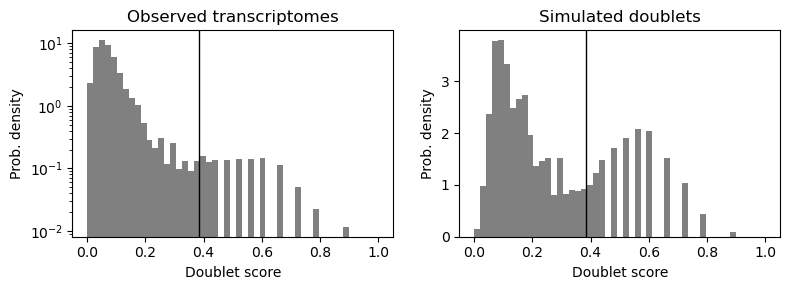

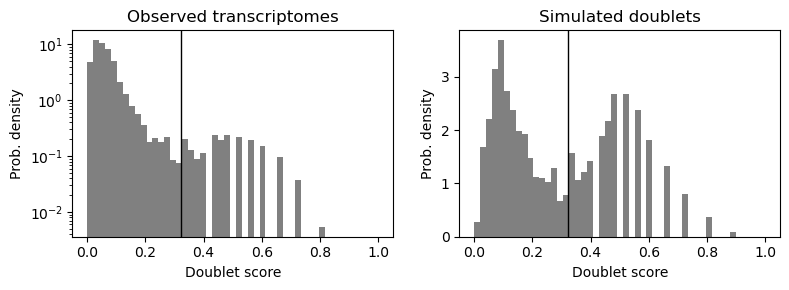

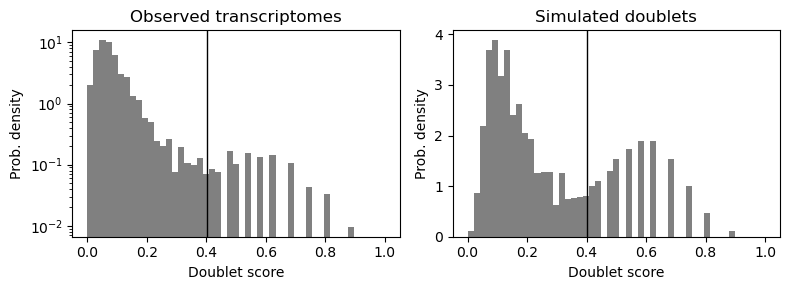

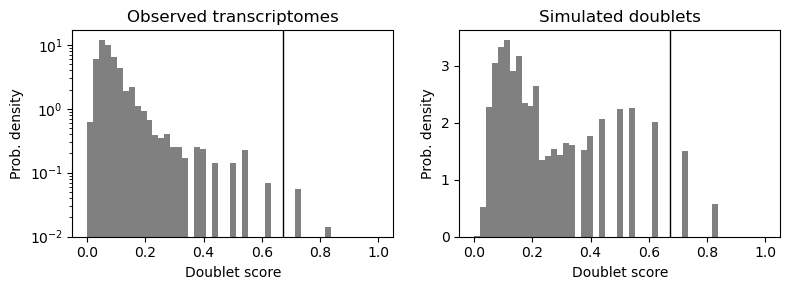

In [3]:
# Read the data
adatas = []
for file in os.listdir(folder_path + 'control/'):
    adatas.append(pp(folder_path + 'control/' + file, 'control'))

for file in os.listdir(folder_path + 'treated/'):
    adatas.append(pp(folder_path + 'treated/' + file, 'treated'))

# Doublet detection
for i in range(len(adatas)):
    adatas[i] = doublet_scr(adatas[i])
    
# Merge the data
adata = sc.concat(adatas,
                  join = 'outer',
                  label = 'sample',
                  keys=[adata.obs['sample'].unique()[0] for adata in adatas])

In [4]:
adata.write_h5ad(folder_path + 'adata.h5ad')